## Importing dependencies

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model

In [2]:
n_class = 5
root_path = "/kaggle/input/kneeoa/"
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

for folder in folder_list:
    for label in range(n_class):
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        label_list += [label] * len(image_list)
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [3]:
df_train_kaggle.shape

(9786, 2)

Text(0, 0.5, 'count')

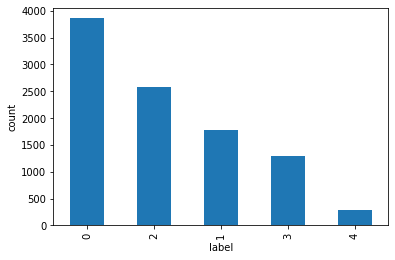

In [4]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [5]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [6]:
# create train generator
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9786 validated image filenames.


In [7]:
# download data from shared google drive link
!pip install gdown
!gdown --id "1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC"

  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - \ | / - done
    Preparing wheel metadata ... - \ | / - done
     |████████████████████████████████| 128 kB 923 kB/s 
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14759 sha256=f71e7c5effcadad3bdab45d6d489c8ac30f4fd564bca8f389034a0798be2a1ae
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC
To: /kaggle/working/KneeXray.zip
100%|█████████████████████████████████████████| 120M/120M [00:00<00:00, 289MB/s]


In [8]:
# unzip the data
!unzip -q -o /kaggle/working/KneeXray.zip -d /kaggle/working/

In [9]:
# read Train.csv file which contains image names and labels and preprocess them
compi_root_path= "/kaggle/working/KneeXray/"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

,filename,label
0,/kaggle/working/KneeXray/train/Image_1.jpg,0
1,/kaggle/working/KneeXray/train/Image_2.jpg,1
2,/kaggle/working/KneeXray/train/Image_3.jpg,0
3,/kaggle/working/KneeXray/train/Image_4.jpg,1
4,/kaggle/working/KneeXray/train/Image_5.jpg,2


Text(0, 0.5, 'count')

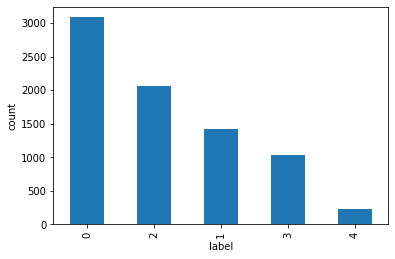

In [10]:
# class count of compitition dataset
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [11]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
dataframe= df_val_compi,
x_col= "filename",
y_col= "label",
batch_size= 32,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 7828 validated image filenames.


In [12]:
xception = Xception(weights="imagenet",)
x=  xception.layers[-3].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

xception_model = Model(inputs=xception.input,outputs=pred)

91889664/91884032 [==============================] - 0s 0us/step


In [13]:
# compile
xception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "xception_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)
]

In [14]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

In [15]:
# train the model
xception_model.fit(
        train_generator,
        epochs=10,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)

Epoch 1/10
306/306 [==============================] - 160s 492ms/step - loss: 1.5383 - acc: 0.2510 - val_loss: 1.6355 - val_acc: 0.2915

Epoch 00001: val_acc improved from -inf to 0.29152, saving model to xception_best.ckpt
Epoch 2/10
306/306 [==============================] - 148s 483ms/step - loss: 1.1752 - acc: 0.4830 - val_loss: 1.5037 - val_acc: 0.3983

Epoch 00002: val_acc improved from 0.29152 to 0.39831, saving model to xception_best.ckpt
Epoch 3/10
306/306 [==============================] - 148s 484ms/step - loss: 1.0299 - acc: 0.5684 - val_loss: 1.2045 - val_acc: 0.5761

Epoch 00003: val_acc improved from 0.39831 to 0.57614, saving model to xception_best.ckpt
Epoch 4/10
306/306 [==============================] - 148s 484ms/step - loss: 0.9251 - acc: 0.6461 - val_loss: 1.1671 - val_acc: 0.6042

Epoch 00004: val_acc improved from 0.57614 to 0.60424, saving model to xception_best.ckpt
Epoch 5/10
306/306 [==============================] - 148s 484ms/step - loss: 0.8317 - acc: 0.7

In [16]:
# train and validation split on competition data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_val_compi,
                                   test_size=0.1,
                                   random_state=42,
                                   stratify= df_val_compi.label)

In [17]:
train_generator = train_aug.flow_from_dataframe(
dataframe = X_train,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 7045 validated image filenames.


In [18]:
valid_generator = valid_aug.flow_from_dataframe( 
dataframe=X_test,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 783 validated image filenames.


In [19]:
# number of steps to consider 1 as  epoch
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID =valid_generator.n//valid_generator.batch_size

In [20]:
# kick off training
# Epoch greater than 5 cause overfitting the dataset
history = xception_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=5,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

Epoch 1/5
220/220 [==============================] - 97s 430ms/step - loss: 0.8902 - acc: 0.8025 - val_loss: 0.7666 - val_acc: 0.8620

Epoch 00001: val_acc improved from 0.77683 to 0.86198, saving model to xception_best.ckpt
Epoch 2/5
220/220 [==============================] - 94s 427ms/step - loss: 0.7799 - acc: 0.8875 - val_loss: 0.8504 - val_acc: 0.8086

Epoch 00002: val_acc did not improve from 0.86198
Epoch 3/5
220/220 [==============================] - 94s 426ms/step - loss: 0.7129 - acc: 0.9286 - val_loss: 0.8297 - val_acc: 0.8542

Epoch 00003: val_acc did not improve from 0.86198
Epoch 4/5
220/220 [==============================] - 94s 426ms/step - loss: 0.6830 - acc: 0.9512 - val_loss: 0.8318 - val_acc: 0.8633

Epoch 00004: val_acc improved from 0.86198 to 0.86328, saving model to xception_best.ckpt
Epoch 5/5
220/220 [==============================] - 94s 428ms/step - loss: 0.6581 - acc: 0.9616 - val_loss: 0.8336 - val_acc: 0.8451

Epoch 00005: val_acc did not improve from 0.8

In [21]:
# load best saved weights
xception_model.load_weights(checkpoint_path)

In [22]:
from sklearn.metrics import precision_recall_curve
target_shape = 224
BATCH_SIZE = 1

# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filename",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )

Found 783 validated image filenames.


In [23]:
# prediction on train data
predicition_compi = xception_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

783/783 [==============================] - 9s 11ms/step


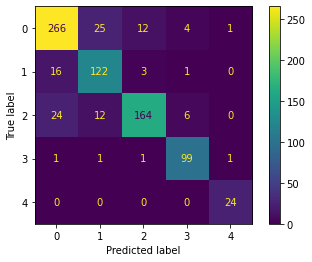

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [25]:
# read the csv file
test = pd.read_csv(compi_root_path + "Test.csv")

# create test generator
test_generator = valid_aug.flow_from_dataframe(
dataframe= test,
directory= compi_root_path + "test",
x_col= "filename",
y_col= None,
batch_size= 1,
seed= 42,
shuffle= False,
class_mode= None,
target_size= (224,224))

# number of steps to consider 1 epoch
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1958 validated image filenames.


In [26]:
# make prediction and create dataframe out of it
pred = xception_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
df_submit = pd.DataFrame({"label":np.argmax(pred, axis= 1)})
df_submit["label"].value_counts()

1958/1958 [==============================] - 21s 11ms/step


0    788
2    482
1    353
3    275
4     60
Name: label, dtype: int64

In [27]:
import sys
import shutil

# Get directory name
mydir = "/kaggle/working"

try:
    shutil.rmtree(mydir)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

Error: /kaggle/working - Device or resource busy.


In [28]:
xception_model.save_weights("knee_xray_Xceptionnet_GPA.h5")
df_submit.to_csv("submission.csv",index=False)

In [29]:
!pip install ann_visualizer
!pip install graphviz

  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=a9224e9cc29347958017cfd57bc2078ac24c920cc65893f24c4957af624e7bd2
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


In [30]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [31]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['acc']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_acc']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [32]:
history.history

{'loss': [0.8902285099029541,
  0.7799321413040161,
  0.7128657102584839,
  0.6829543709754944,
  0.6580817103385925],
 'acc': [0.802509605884552,
  0.8874946236610413,
  0.928561270236969,
  0.951233446598053,
  0.9616426825523376],
 'val_loss': [0.766570508480072,
  0.8503801822662354,
  0.8297130465507507,
  0.8318091034889221,
  0.8335604667663574],
 'val_acc': [0.8619791865348816,
  0.80859375,
  0.8541666865348816,
  0.86328125,
  0.8450520634651184],
 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05]}

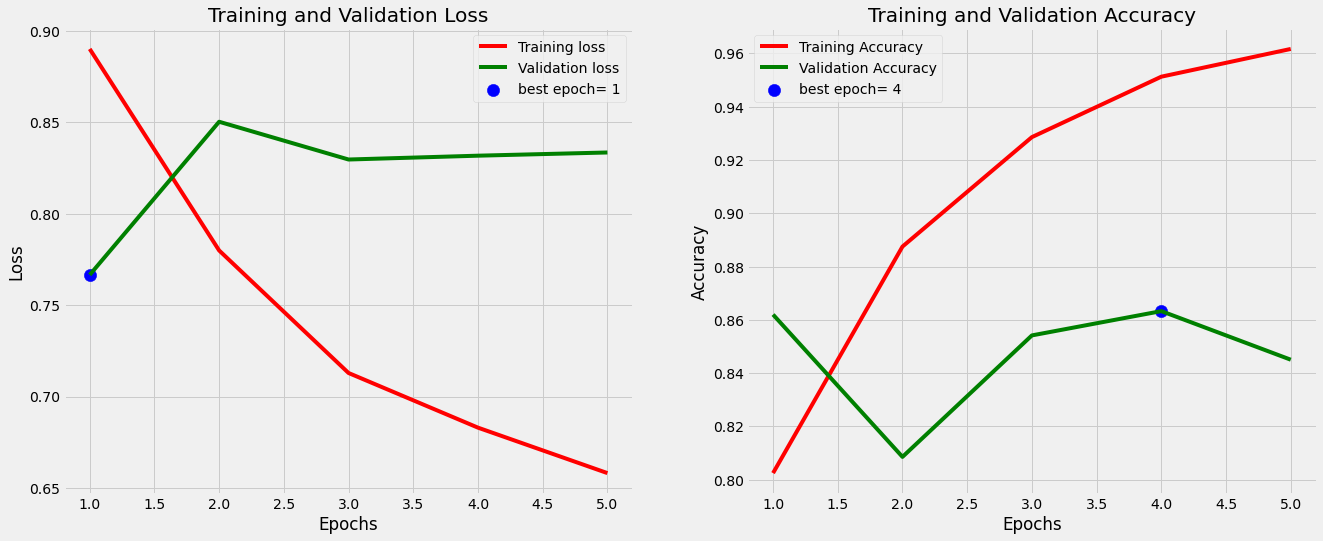

In [33]:
tr_plot(history, 0) 

In [34]:
from sklearn.metrics import classification_report

print(classification_report(X_test.label, list(class_prediction_compi), labels=[0, 1, 2, 3, 4]))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       308
           1       0.76      0.86      0.81       142
           2       0.91      0.80      0.85       206
           3       0.90      0.96      0.93       103
           4       0.92      1.00      0.96        24

    accuracy                           0.86       783
   macro avg       0.87      0.90      0.88       783
weighted avg       0.87      0.86      0.86       783

